In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [77]:
import json
import requests

# using the API endpoint to get the user data in DynamoDB
URL = 'https://smart-parking-iotprogramming.herokuapp.com/api/users'
obj = requests.get(URL).json()
users = obj['users']

In [78]:
# convert the json to DataFrame
raw_df = pd.DataFrame(columns=['user_id', 'ts', 'user_fee'])
for user in users:
    obj = {
        'user_id': user['user_id'],
        'ts': user['ts_payment'],
        'user_fee': user['user_fee']
    }
    raw_df = raw_df.append(obj, ignore_index=True)
    
raw_df

,user_id,ts,user_fee
0,896.0,2020-05-26 14:48:10.734,24
1,3396.0,2020-05-29 15:34:04,15
2,5619.0,2020-06-01 11:13:56,14
3,123.0,2020-05-27 17:19:41,20
4,6454.0,2020-05-26 13:37:36.258,22
5,4730.0,2020-05-25 12:11:51.264,17
6,987.0,2020-05-28 15:06:08,15
7,2952.0,2020-06-01 09:17:16,28
8,1102.0,2020-06-01 13:58:41.45,22
9,2934.0,2020-05-30 13:00:15.988,10


In [79]:
# Convert the datatypes accordingly
# set the date to datetime format
raw_df['user_fee'] = raw_df['user_fee'].astype('float64')
raw_df['ts'] = pd.to_datetime(raw_df['ts'])
raw_df.dtypes

user_id            float64
ts          datetime64[ns]
user_fee           float64
dtype: object

In [80]:
# group the data based on the day
g = raw_df.groupby(raw_df['ts'].dt.date)
tdf = pd.DataFrame(columns=['ts', 'user_fee', 'total_user'])

# create a new dataset that contains the day, average user fee and total user
for k in g.groups.keys():
    tdf = tdf.append({
        'ts': k,
        'user_fee': g.get_group(k).mean()['user_fee'],
        'total_user': g.get_group(k).count()['user_id']
    }, ignore_index=True)
tdf

,ts,user_fee,total_user
0,2020-05-25,16.00,2
1,2020-05-26,20.75,4
2,2020-05-27,20.00,1
3,2020-05-28,15.00,1
4,2020-05-29,15.00,1
5,2020-05-30,10.00,1
6,2020-06-01,24.00,5


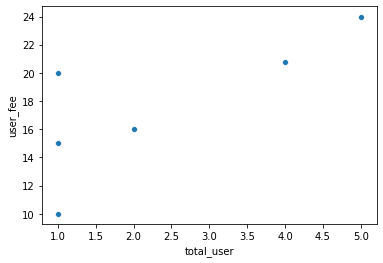

In [81]:
# plot the dataframe
sns.scatterplot(data=tdf, x='total_user', y='user_fee')

In [109]:
# define the X and Y
X = tdf['total_user'].values.reshape(-1,1)
y = tdf['user_fee']

In [113]:
from sklearn.linear_model import LinearRegression

# train the linear model
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

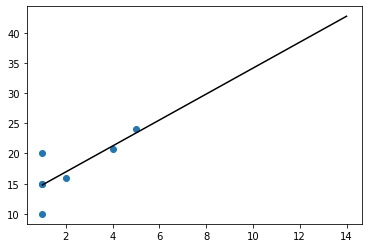

In [114]:
# plot the actual data and the prediction
plt.scatter(X, y)
test_X = np.array(list(range(1, 15)))
test_X = test_X.reshape(-1, 1)
plt.plot(test_X, model.predict(test_X),color='k')